# Project 3 - A Tale of Two Subreddits
---

## Background
---

One of the most popular and widely-used repositories of old Reddit data, [Pushshift](https://files.pushshift.io/reddit/) (the same Pushshift whose API I will use to scrape Reddit!) has run into an issue. While archiving some late 2020 data from r/Conservative and r/neoliberal posts, the two files were merged and mixed in a clerical error. The data about where each post came from and the post authors were deleted, and now the archivists have to recategorize these posts one by one.

The problem with this, though, is that data is continually coming in from Reddit, and since the Pushshift archives are maintained by volunteers, resources are spread thin. This is where machine learning can come in to save the day!

Since all of the available data (other than the date of posting) is in the form of text, I will be using **N**atural **L**anguage **P**rocessing (NLP) to turn this data into a form a computer model can understand. From here I will plug the data into the following classification models:

1. A Multinomial Naive Bayes classifier
2. A Random Forest Classifier

Whichever model performs best on a selection of test data will be used to automatically categorize the missing posts and save the Pushshift team a lot of time!

## Problem Statement
---

The main goal of this project will be to create two classifiers that can accurately recognize whether a reddit post was made to r/Conservative or r/neoliberal using only the title of the post and the description of the post.

## Data Loading 
---

The first thing that needs to be done is to use the Reddit RESTful API [Pushshift](https://github.com/pushshift/api). Here, I will use the API to scape data from **r/Conservative** and **r/neoliberal**. I chose to gather 100 posts from each subreddit every three days to try and keep the resulting dataset as balanced as possible. 

This *3 day* metric was chosen because I wanted to make sure that the API had 100 posts to choose from for each chunk of data. Based on statistics from [subredditstats](https://subredditstats.com/), both subreddits produce 100 posts about every 1.5 days, so I chose 3 days to try and account for variance.

In [1]:
import requests
import numpy as np
import pandas as pd
import time
from datetime import date

In [2]:
# Create a function to do this whole data gathering process
def subreddit_wrangler(sdate, edate, sub_a, sub_b, frequency='3D'):
    """Takes in a start and end date from which to gather posts from two subreddits, a and b."""
    
    # Convert the inputted dates to a range of dates, and convert to unix time
    date_list = pd.date_range(start=sdate, end=edate, freq='3D')
    epoch_list = date_list.astype(np.int64) // (10**9) ## Convert from nanoseconds to seconds
    
    # Set the url - assuming this function will always be used for submissions
    url = 'https://api.pushshift.io/reddit/search/submission'
    df = pd.DataFrame(columns=['selftext', 'subreddit', 'title']) ## Will return this dataframe

    for i, date in enumerate(epoch_list):
        # Trying to prevent the out of index error
        if epoch_list[i + 1] == epoch_list[-1]:
            return df

        # For the neoliberal posts
        params = {
            'subreddit' : sub_a,
            'size'      : 100,
            'fields'    : ['title', 'subreddit', 'selftext'],
            'after'     : date,
            'before'    : epoch_list[i + 1]
        }
        res_a = requests.get(url, params=params)
        print(res_a.status_code)
        data_a = res_a.json()
        posts_a = data_a['data']
        raw_df_a = pd.DataFrame(posts_a)

        # Wait 3 seconds before the next request
        time.sleep(3)

        # For the conservative posts
        params['subreddit'] = sub_b
        res_b = requests.get(url, params=params)
        print(res_b.status_code)
        data_b = res_b.json()
        posts_b = data_b['data']
        raw_df_b = pd.DataFrame(posts_b)

        # Concat
        data_chunk = pd.concat([raw_df_b, raw_df_a])

        # Update the time frame
        df = df.append(data_chunk)

        # Wait 3 seconds before the next request
        time.sleep(3)

In [3]:
data = subreddit_wrangler(sdate=date(2021, 1, 28), edate=date(2021, 6, 28), sub_a='neoliberal', sub_b='Conservative')

200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200


## Data Cleaning 
---

Now that the data is loaded in, let's check it out to make sure there are no nulls, and to make sure all columns are numerical. I will also make sure the classes of the target (which subreddit the post came from) are balanced.

In [4]:
data.shape

(9090, 3)

In [5]:
data.isnull().sum() # Most nulls are replaced with [removed] or [deleted] or ""

selftext     26
subreddit     0
title         0
dtype: int64

In [6]:
# Drop these nulls, since there so few
data.dropna(inplace=True)

In [7]:
data['subreddit'].value_counts(normalize=True)

Conservative    0.505516
neoliberal      0.494484
Name: subreddit, dtype: float64

The classes aren't *perfectly* balanced, but they are still pretty close. The fact that I dropped a few nulls and possible variance in the number of posts on either subreddit probably led to this slight imbalance.

This also gives us the **baseline model - 50.5%**.

In [8]:
data['selftext'].value_counts()

The `selftext` feature is full of nulls and empty values - most posts in these subreddits don't have descriptions. To save the entries that do exist, I will concatenate the `selftext` and `title` features (*thanks for the suggestion Noah!*)

In [9]:
# Simply add the strings - add a whitespace to make sure the vectorizer can recognize all of the words
data['text'] = data.apply(lambda x: x['selftext'] + " " + x['title'], axis=1)
data.head()

,selftext,subreddit,title,text
0,,Conservative,John Kerry Declares Biden Administration Will ...,John Kerry Declares Biden Administration Will...
1,,Conservative,Illegal Immigration and ‘Racial Equity’,Illegal Immigration and ‘Racial Equity’
2,[deleted],Conservative,Of course it is,[deleted] Of course it is
3,[removed],Conservative,The Future of the GOP,[removed] The Future of the GOP
4,,Conservative,Joe Biden to Ban New Fracking Leases on Federa...,Joe Biden to Ban New Fracking Leases on Feder...


Next, binarize the target column `subreddit`:

In [10]:
# Binarize - 0 will represent Conservative, 1 neoliberal
data['Target_col'] = data['subreddit'].map({'Conservative' : 0, 'neoliberal' : 1})

## Dataset Saving
---

Before I begin vectorizing and modeling, I will save this form of the data so that I have something to come back to in case of emergency (without having to wait 5 minutes to request data from Reddit).

In [11]:
data.to_csv('../datasets/raw_text_data.csv', index=False)

The dataset I am saving here can be described with the following data dictionary:

|Feature|Type|Description|
|---|---|---|
|**selftext**|*object*|The description of a post|
|**subreddit**|*object*|The source of the post, either Conservative or neoliberal|
|**title**|*object*|The title of the post|
|**text**|*object*|A concatenation of the `title` and `selftext` features|
|**Target_col**|*object*|The **target** of the data - A binarization of `subreddit` where 0 represented r/Conservative and 1 represented r/neoliberal.|

## EDA
---

To perform more complex EDA on this data, I will need to vectorize the text. To do this, I will use `CountVectorizer` along with the standard visualization libraries: 

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

In [13]:
# Transform the data and place the output into a new dataframe
stop_words = nltk.corpus.stopwords.words('english')

# Add [removed] and [deleted] as stop words - they don't add value to the dataset
stop_words = stop_words + ['deleted', 'removed']

In [14]:
def feature_plotter(text, plot_title, save_as):
    """Make a bar plot of the ten most frequent words in a corpus. save_as should be a 
    relative path to the place you want to save the figure plus the filename."""
    tvec = TfidfVectorizer(stop_words=stop_words)

    text_df = pd.DataFrame(tvec.fit_transform(text).todense(), 
                              columns=tvec.get_feature_names())
    # Make a nice barplot
    plt.figure(figsize=(12, 8))
    text_df.sum().sort_values(ascending=False).head(10).plot(kind='barh')
    plt.title(plot_title)
    plt.xlabel('Word Frequency')
    plt.ylabel('Words')
    plt.savefig(save_as)
    plt.show()
    return 

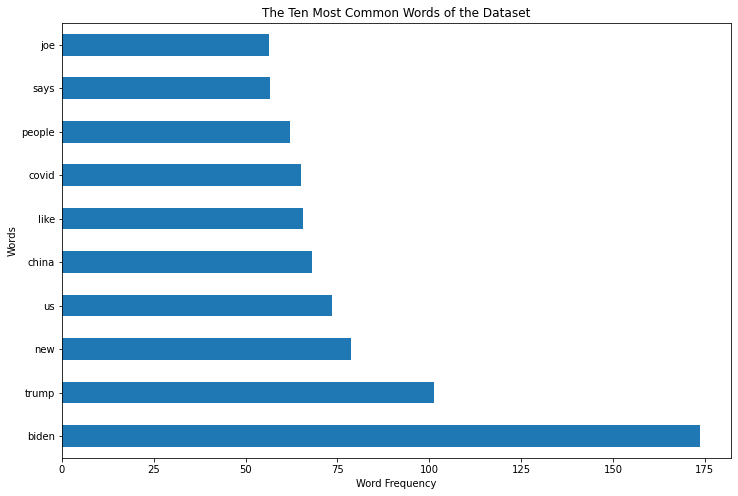

In [15]:
feature_plotter(data['text'], 'The Ten Most Common Words of the Dataset', '../assets/overall_word_freq.png')

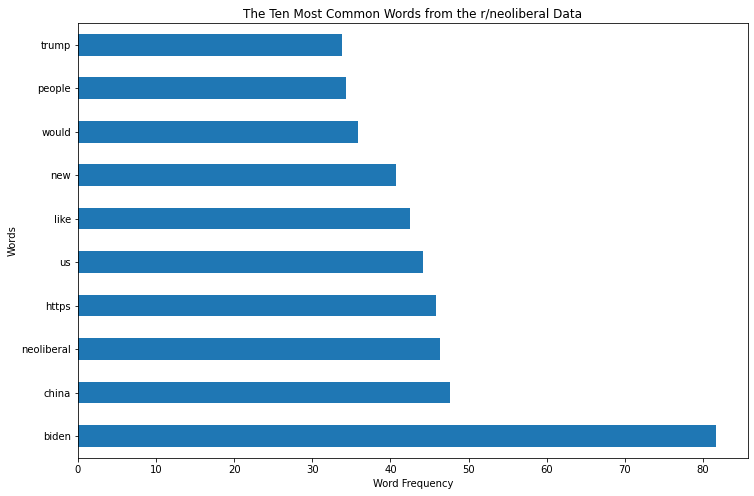

In [18]:
# Now check the word frequencies of the two subreddits
text_neolib = data.loc[data['Target_col'] == 1, ['text']]
feature_plotter(text_neolib['text'], 'The Ten Most Common Words from the r/neoliberal Data', '../assets/neolib_word_freq.png')

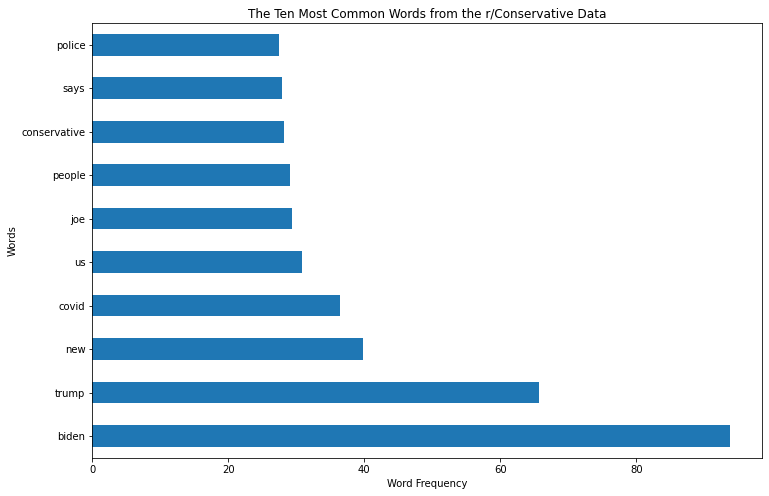

In [19]:
text_con = data.loc[data['Target_col'] == 0, ['text']]
feature_plotter(text_con['text'], 'The Ten Most Common Words from the r/Conservative Data', '../assets/con_word_freq.png')

There are a lot of takeaways here:
1. Biden is the most popular word in both of the subreddits by far (other than removed stop words). This might make classification harder because the word "biden" will strongly correlate with both subreddits.
2. In both subreddits, one of the top ten words is the name of the subreddit. This should make classfication *much* easier.
3. The inclusion of "https" in the neoliberal data is interesting. This must be the result of titles or selftext inlcuding a url. This implies that neoliberal subreddit posts include links to other sites often. This will also be useful in classification, as this might not be the case in r/Conservative.

Now that some EDA has been performed, let's move onto the modeling portion of this project. This can be found in the [next notebook.]('02_modeling_conclusions.ipynb')